In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import cv2 as cv
import open3d
import numpy as np

from utils.io_utils import get_matching_pairs, get_nearest_files, \
                            get_images, get_depths, \
                            get_azure_parameters, get_charuco_parameters
from utils.calib_utils import detect_charuco_keypoints, \
                                undistort_intrinsics, undistort_images, \
                                to_homogeneous, to_cartesian, pointcloudify_kp, to_normalized_image_coord, project2image, \
                                plane2plane_transformation, compose_fund_mat, optimize_pose_lm, pointcloudify_depths, optimize_translation_lm_mutual, average_transforms, align_charuco_detections, pointcloudify_azure_keypoints
from utils.vis_utils import plot_figures, plot_projected_keypoints, plot_projected_pcd, to_open3d, plot_epipolar_lines_points, draw_charuco_corners, normalize_image, draw_points

np.set_printoptions(suppress=True)

### Load data

In [32]:
img_ext = ".png"
depth_ext = ".png"

start = 0
period = 1

In [33]:
base_dir = "/Users/Konstantin/Desktop/new_samsung"

In [34]:
azure_images_path1 = f"{base_dir}/3m/color"
azure_images_path2 = f"{base_dir}/5s/color"

azure_depths_path1 = f"{base_dir}/3m/depth"
azure_depths_path2 = f"{base_dir}/5s/depth"

In [35]:
az_img_ts1, az_img_ts2 = get_matching_pairs(azure_images_path1, azure_images_path2,
                                            start=start, period=period)

az_img_ts1, az_depth_ts1 = get_nearest_files(az_img_ts1, azure_depths_path1)
az_img_ts2, az_depth_ts2 = get_nearest_files(az_img_ts2, azure_depths_path2)

In [36]:
azure_images1 = get_images(azure_images_path1, file_name_list=[fn + img_ext for fn in az_img_ts1])
azure_images2 = get_images(azure_images_path2, file_name_list=[fn + img_ext for fn in az_img_ts2])

In [37]:
azure_depths1 = get_depths(azure_depths_path1, file_name_list=[fn + depth_ext for fn in az_depth_ts1])
azure_depths2 = get_depths(azure_depths_path2, file_name_list=[fn + depth_ext for fn in az_depth_ts2])

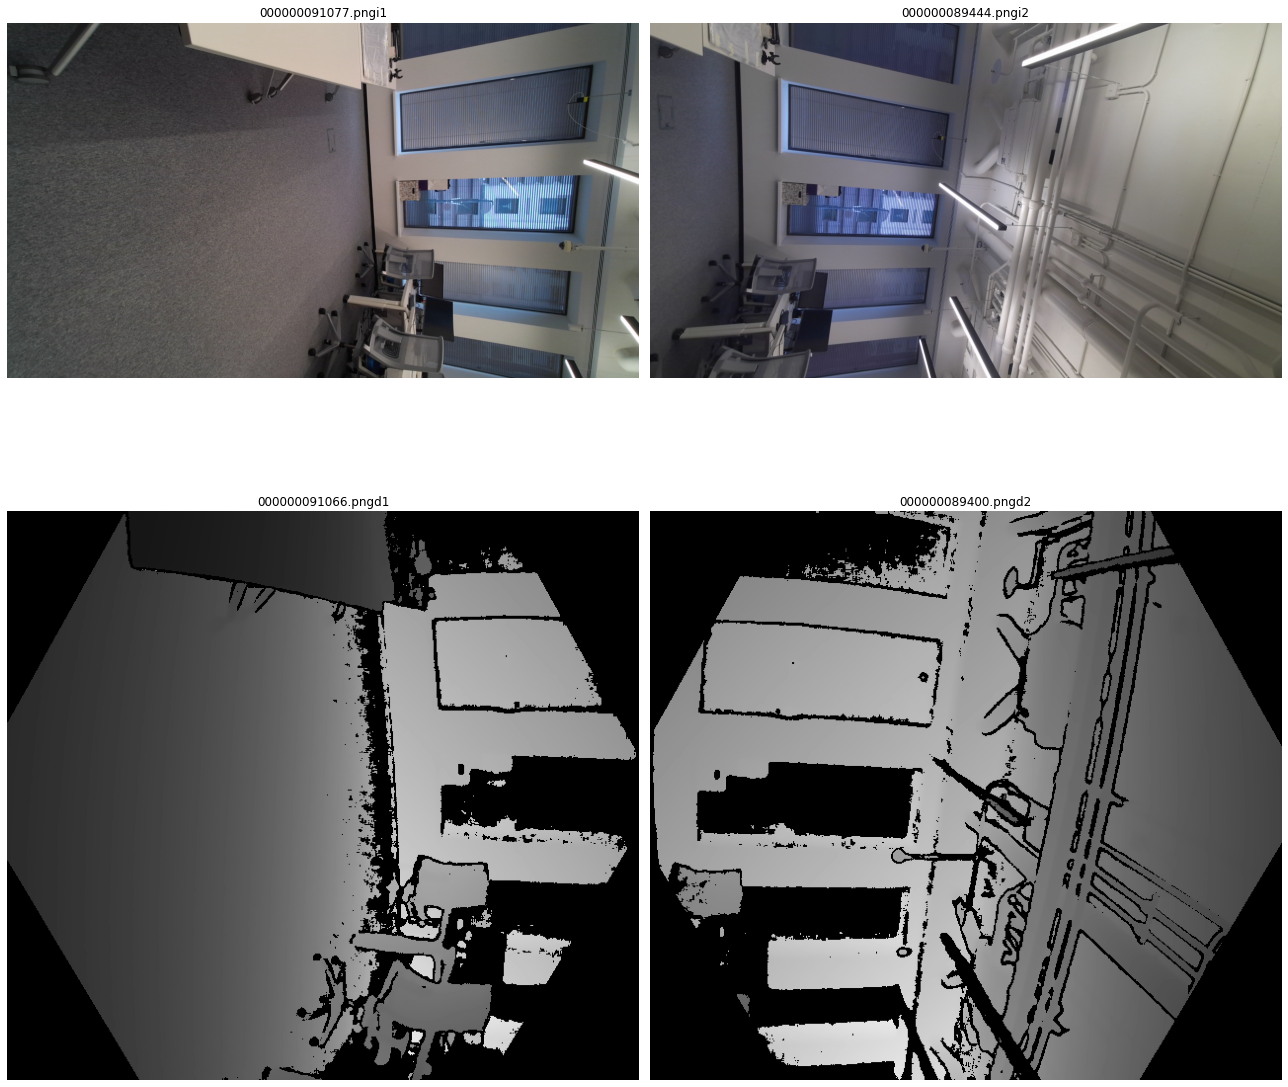

In [38]:
idx = 0

plot_figures({az_img_ts1[idx] + img_ext + 'i1': azure_images1[az_img_ts1[idx] + img_ext], 
              az_img_ts2[idx] + img_ext + 'i2': azure_images2[az_img_ts2[idx] + img_ext],
              
              az_depth_ts1[idx] + depth_ext + 'd1': azure_depths1[az_depth_ts1[idx] + depth_ext],
              az_depth_ts2[idx] + depth_ext + 'd2': azure_depths2[az_depth_ts2[idx] + depth_ext]}, 2, 2)

In [39]:
az_img_extrinsics1, az_img_intrinsics1, az_depth_intrinsics1, az_img_dist_coeffs1, az_depth_dist_coeffs1, az_img_size1, az_depth_size1 = get_azure_parameters(f"{base_dir}/3m/calib_params.json")
az_img_extrinsics2, az_img_intrinsics2, az_depth_intrinsics2, az_img_dist_coeffs2, az_depth_dist_coeffs2, az_img_size2, az_depth_size2 = get_azure_parameters(f"{base_dir}/5s/calib_params.json")

In [40]:
az_img_uintrinsics1 = undistort_intrinsics(az_img_size1, az_img_intrinsics1, az_img_dist_coeffs1)
az_depth_uintrinsics1 = undistort_intrinsics(az_depth_size1, az_depth_intrinsics1, az_depth_dist_coeffs1)

az_img_uintrinsics2 = undistort_intrinsics(az_img_size2, az_img_intrinsics2, az_img_dist_coeffs2) 
az_depth_uintrinsics2 = undistort_intrinsics(az_depth_size2, az_depth_intrinsics2, az_depth_dist_coeffs2)

In [41]:
azure_uimages1 = undistort_images(azure_images1,
                                  az_img_intrinsics1, az_img_dist_coeffs1,
                                  az_img_uintrinsics1,
                                  cv.INTER_LINEAR)
azure_uimages2 = undistort_images(azure_images2,
                                  az_img_intrinsics2, az_img_dist_coeffs2,
                                  az_img_uintrinsics2,
                                  cv.INTER_LINEAR)

azure_udepths1 = undistort_images(azure_depths1,
                                  az_depth_intrinsics1, az_depth_dist_coeffs1,
                                  az_depth_uintrinsics1,
                                  cv.INTER_LINEAR)
azure_udepths2 = undistort_images(azure_depths2,
                                  az_depth_intrinsics2, az_depth_dist_coeffs2,
                                  az_depth_uintrinsics2,
                                  cv.INTER_LINEAR)

In [42]:
del azure_images1, azure_images2
del azure_depths1, azure_depths2

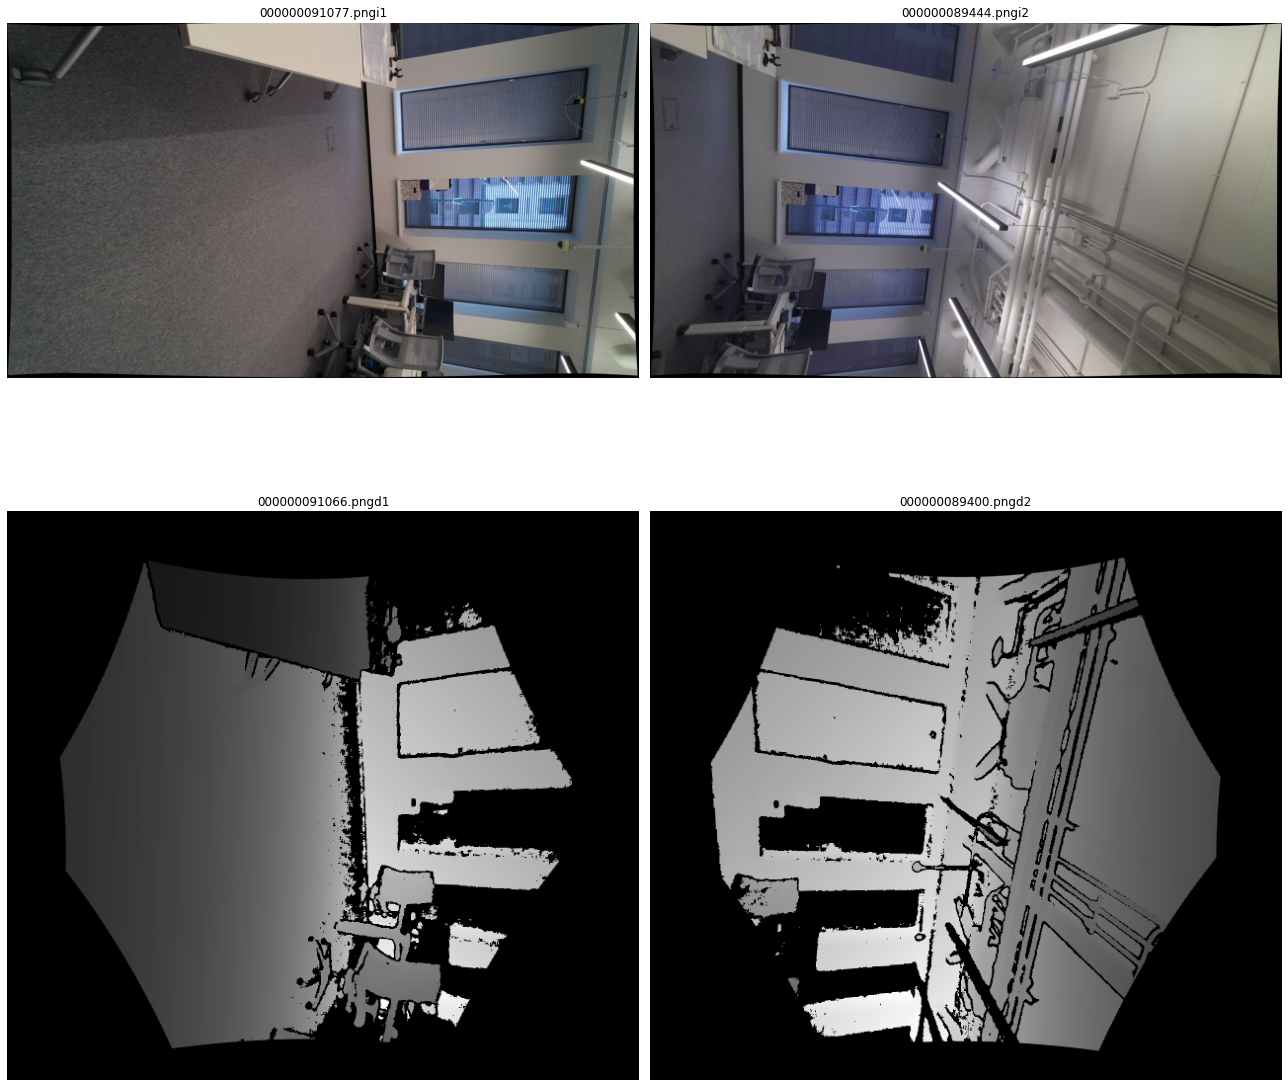

In [43]:
idx = 0

plot_figures({az_img_ts1[idx] + img_ext + 'i1': azure_uimages1[az_img_ts1[idx] + img_ext], 
              az_img_ts2[idx] + img_ext + 'i2': azure_uimages2[az_img_ts2[idx] + img_ext],
              
              az_depth_ts1[idx] + depth_ext + 'd1': azure_udepths1[az_depth_ts1[idx] + depth_ext],
              az_depth_ts2[idx] + depth_ext + 'd2': azure_udepths2[az_depth_ts2[idx] + depth_ext]}, 2, 2)

## Detect charuco keypoints

In [16]:
squares_x, squares_y, square_length, marker_length = get_charuco_parameters(f"{base_dir}/plane_samsung_large_new.json")

In [17]:
azure_detections1 = detect_charuco_keypoints(azure_uimages1,
                                             squares_x, squares_y,
                                             square_length,
                                             marker_length)

azure_detections2 = detect_charuco_keypoints(azure_uimages2,
                                             squares_x, squares_y,
                                             square_length,
                                             marker_length)

In [18]:
azure_det_mask1 = np.array([ts in azure_detections1 for ts in az_img_ts1])
azure_det_mask2 = np.array([ts in azure_detections2 for ts in az_img_ts2])

det_mask = azure_det_mask1 & azure_det_mask2

az_img_ts1, az_img_ts2 = az_img_ts1[det_mask], az_img_ts2[det_mask]
az_depth_ts1, az_depth_ts2 = az_depth_ts1[det_mask], az_depth_ts2[det_mask]

In [19]:
idx = 0

plot_figures({az_img_ts1[idx] + img_ext + '1': draw_charuco_corners(azure_uimages1[az_img_ts1[idx] + img_ext], 
                                                                    azure_detections1[az_img_ts1[idx]][0], 
                                                                    azure_detections1[az_img_ts1[idx]][1]),
              az_img_ts2[idx] + img_ext + '2': draw_charuco_corners(azure_uimages2[az_img_ts2[idx] + img_ext], 
                                                                    azure_detections2[az_img_ts2[idx]][0], 
                                                                    azure_detections2[az_img_ts2[idx]][1])}, 1, 2)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
aligned_detections1, aligned_detections2 = align_charuco_detections(azure_detections1, azure_detections2)

## Azures to chessboard

In [86]:
def azure2chess(az_img_ts, az_depth_ts,
                aligned_detections, azure_udepths,
                az_img_extrinsics, az_img_uintrinsics, az_depth_uintrinsics):
    azure_chess = {}
    
    for img_ts, depth_ts in zip(az_img_ts, az_depth_ts):
        kp = aligned_detections[img_ts]
        depth = azure_udepths[depth_ts + depth_ext]
        
        local_kp = pointcloudify_azure_keypoints(kp, depth,
                                                 az_img_extrinsics, 
                                                 az_img_uintrinsics, az_depth_uintrinsics)
        
        local_kp = local_kp[local_kp[:, 2] > 0.1]
        
        azure_chess[img_ts] = local_kp
    
    return azure_chess

In [87]:
azure_chess1 = azure2chess(az_img_ts1, az_depth_ts1,
                           aligned_detections1, azure_udepths1,
                           az_img_extrinsics1, az_img_uintrinsics1, az_depth_uintrinsics1)

azure_chess2 = azure2chess(az_img_ts2, az_depth_ts2,
                           aligned_detections2, azure_udepths2,
                           az_img_extrinsics2, az_img_uintrinsics2, az_depth_uintrinsics2)

In [88]:
idx = 1

open3d.visualization.draw_geometries([to_open3d(azure_chess1[az_img_ts1[idx]]),
                                      to_open3d(azure_chess2[az_img_ts2[idx]])])

## Relative pose. Initial guess 

In [89]:
init_extrinsics = {}

for ts1, ts2 in zip(az_img_ts1, az_img_ts2):
    init_extrinsics[ts1 + ' ' + ts2] = plane2plane_transformation(azure_chess1[ts1], azure_chess2[ts2])

In [90]:
idx = 1

idx_extr = init_extrinsics[az_img_ts1[idx] + ' ' + az_img_ts2[idx]]


open3d.visualization.draw_geometries([to_open3d(to_cartesian((idx_extr @ to_homogeneous(azure_chess1[az_img_ts1[idx]]).T).T)),
                                      to_open3d(azure_chess2[az_img_ts2[idx]])])


## Relative pose. Optimization

In [185]:
opt_extrinsics = {}

best_t_norm = 1e+9
best_t_norm_key = ""

for ts1, ts2 in zip(az_img_ts1, az_img_ts2):
    kp1, kp2 = aligned_detections1[ts1], aligned_detections2[ts2]
    
    print(f"Keys {ts1}, {ts2}")
    print("R")
    opt_extr = optimize_pose_lm(init_extrinsics[ts1 + ' ' + ts2],
                                kp1, kp2,
                                az_img_uintrinsics1, az_img_uintrinsics2)  
    
    if opt_extr is not None:
        print("t")
        
        local_kp1, local_kp2 = azure_chess1[ts1], azure_chess2[ts2]
        
        opt_extr, t_norm = optimize_translation_lm(opt_extr,
                                                   local_kp1, 
                                                   kp2,
                                                   az_img_uintrinsics2)
        
#         opt_extr, t_norm = optimize_translation_lm_mutual(opt_extr,
#                                                           local_kp1, local_kp2, 
#                                                           kp1, kp2, 
#                                                           az_img_uintrinsics1, az_img_uintrinsics2)
        
        opt_extrinsics[ts1 + ' ' + ts2] = opt_extr
        
        if t_norm < best_t_norm:
            best_t_norm = t_norm
            best_t_norm_key = ts1 + ' ' + ts2
        
    print()

Keys 000003389400, 000003384455
R
Avg. epipolar distance: 0.5742641720593309
Number of iters: 35
t
Avg. l2-norm: 16.610108322093385
Number of iters: 16
Translation scale: 0.08257940997483695

Keys 000003589422, 000003584488
R
Avg. epipolar distance: 0.054487586138169196
Number of iters: 15
t
Avg. l2-norm: 1.8262185474240125
Number of iters: 20
Translation scale: 0.3349838794877038

Keys 000003789455, 000003784511
R
Avg. epipolar distance: 0.061502736074118436
Number of iters: 17
t
Avg. l2-norm: 1.9415587105624128
Number of iters: 22
Translation scale: 0.3327911070234915

Keys 000003989388, 000003984466
R
Avg. epipolar distance: 0.5109827885032729
Number of iters: 58
t
Avg. l2-norm: 13.747016413937367
Number of iters: 17
Translation scale: 0.16157819005547044



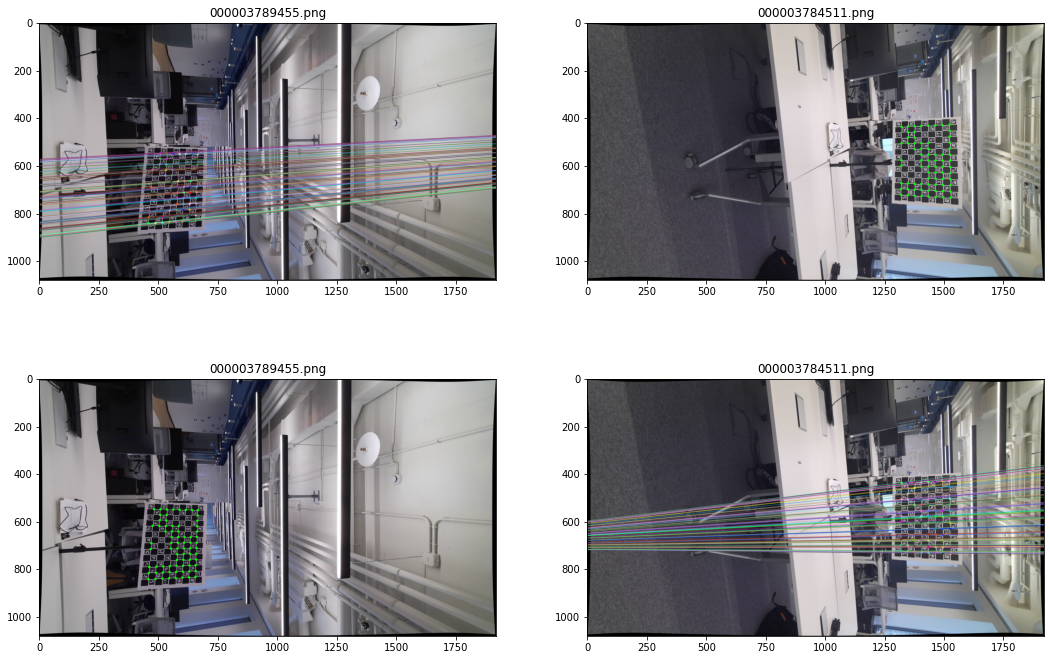

In [192]:
idx = 2

F = compose_fund_mat(opt_extrinsics[az_img_ts1[idx] + ' ' + az_img_ts2[idx]],
                     az_img_uintrinsics1, az_img_uintrinsics2)

plot_epipolar_lines_points(azure_uimages1[az_img_ts1[idx] + img_ext],
                           azure_uimages2[az_img_ts2[idx] + img_ext],
                           aligned_detections1[az_img_ts1[idx]].astype(np.int),
                           aligned_detections2[az_img_ts2[idx]].astype(np.int),
                           az_img_ts1[idx] + img_ext, az_img_ts2[idx] + img_ext,
                           F)

##  Visualization of the solution

In [81]:
opt_extrinsics = np.array([[ 0.7369814293238831, 0.06116108941114726, 0.6731401740898905, 0.20614468710692146],
                           [-0.054360895146189636, 0.998034909423988, -0.031164284845909912, -0.009223584142494912],
                           [-0.6737234342893464, -0.013625003232793002, 0.7388579656309288, -0.10409924579838647],
                           [0, 0, 0, 1]])

opt_extrinsics = np.linalg.inv(opt_extrinsics)

In [82]:
az_pcd_depths1 = pointcloudify_depths(azure_udepths1, az_depth_uintrinsics1)
az_pcd_depths2 = pointcloudify_depths(azure_udepths2, az_depth_uintrinsics2)

In [88]:
idx = 18

img_key1, img_key2 = az_img_ts1[idx], az_img_ts2[idx]
depth_key1, depth_key2 = az_depth_ts1[idx] + depth_ext, az_depth_ts2[idx] + depth_ext

local_img_pcd2 = to_cartesian((opt_extrinsics @ az_img_extrinsics1 @ to_homogeneous(local_depth_pcd1).T).T)
local_img_pcd1 = to_cartesian((np.linalg.inv(opt_extrinsics) @ az_img_extrinsics2 @ to_homogeneous(local_depth_pcd2).T).T)


In [89]:
# img_key1, img_key2 = best_t_norm_key.split(' ')
# index = np.where(az_img_ts1 == img_key1)[0].item()

# depth_key1, depth_key2 = az_depth_ts1[index] + depth_ext, az_depth_ts2[index] + depth_ext

# local_depth_pcd1, local_depth_pcd2 = az_pcd_depths1[depth_key1], az_pcd_depths2[depth_key2]

# local_img_pcd2 = to_cartesian((opt_extrinsics[best_t_norm_key] @ az_img_extrinsics1 @ to_homogeneous(local_depth_pcd1).T).T)
# local_img_pcd1 = to_cartesian((np.linalg.inv(opt_extrinsics[best_t_norm_key]) @ az_img_extrinsics2 @ to_homogeneous(local_depth_pcd2).T).T)

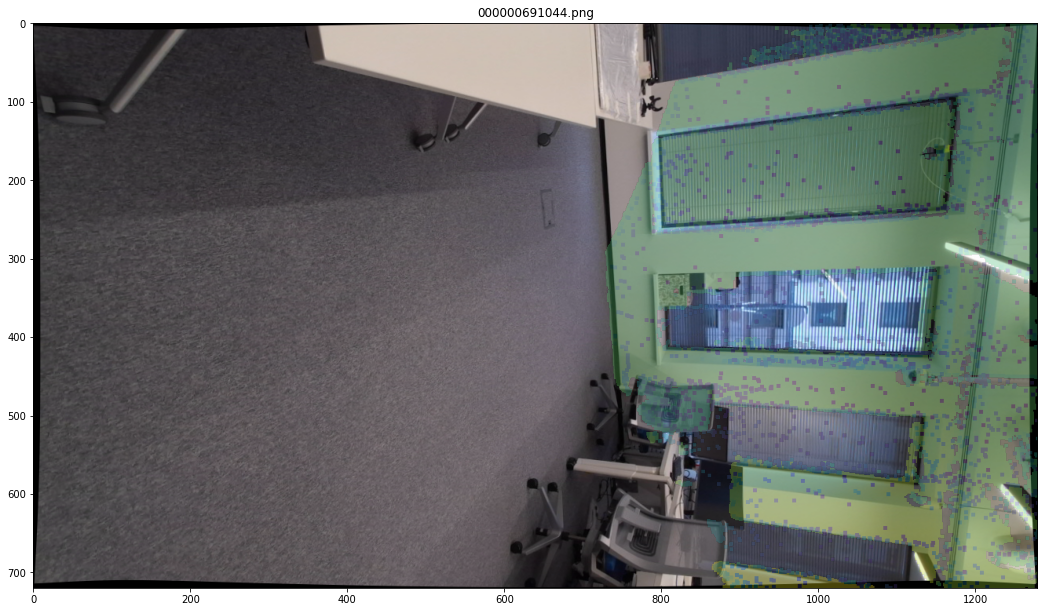

In [90]:
plot_projected_pcd(azure_uimages1[img_key1 + img_ext],
                   local_img_pcd1, az_img_uintrinsics1,
                   img_key1 + img_ext)

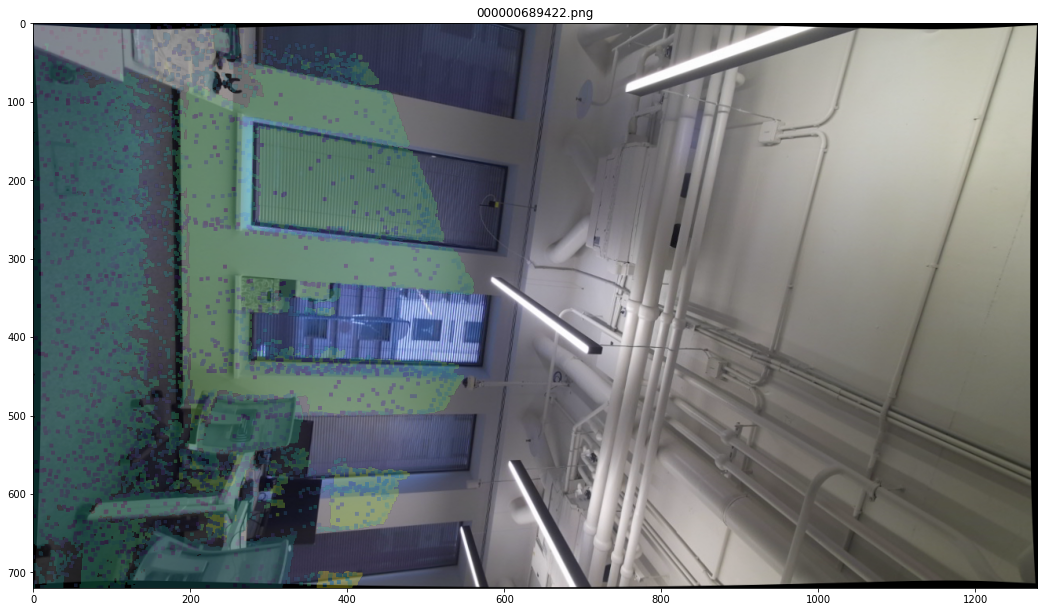

In [91]:
plot_projected_pcd(azure_uimages2[img_key2 + img_ext],
                   local_img_pcd2, az_img_uintrinsics2,
                   img_key2 + img_ext)